<center> <h1> <span style="color:black"> Machine Learning in Actuarials </h1> </center> 
<center> <h2> <span style="color:red"> GLM Frequency and Severity </h1> </center>
<center> <h3> <span style="color:black"> Author: Marino San Lorenzo </h1> </center>

# Agenda
* [Chapter 1 - Data Exploration](#one)
    + [1.1 univariate analysis of numerical data](#one-one)
    + [1.2 univariate analysis of categorical data](#one-two)
    + [1.3 bivariate analysis of numerical data](#one-three)
    + [1.4 bivariate analysis of categorical data](#one-four)
* [Chapter 2 - Feature Engineering](#two)
    + [2.1 Processing with Binning continuous variables](#two-one)
        + [2.1.1 Dummy Coding with reference class](#two-one-one)
* [Chapter 3 - Modelling](#three)
    + [3.1 Regression Trees](#three-one)
    + [3.2 Random Forest](#three-two)
    + [3.3 Gradient Boosting ](#three-three)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from src.constants import Constants, params

from src.styling import *
from src.utils import *
from src.plots import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from collections import defaultdict
from matplotlib import cm
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.2f}'.format)

In [3]:
test_size, random_state = params.get(Constants.TEST_SIZE), params.get(Constants.RANDOM_STATE)
nb_claims_name, claim_amount_name = params.get(Constants.NB_CLAIMS), params.get(Constants.CLAIM_AMOUNT)
claim_frequency_name = params.get(Constants.CLAIM_FREQUENCY)
exposure_name = params.get(Constants.EXPOSURE_NAME)

In [4]:
df = pd.read_csv(params.get(Constants.URL_LINK_TO_DATA), delimiter = ",")
df.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.00,0.00,0,0.00,0.00,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.05,-3.07,1,21.47,155.97,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.40,-0.91,0,0.00,0.00,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.17,-1.77,0,0.00,0.00,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.00,0.00,0,0.00,0.00,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


# 1. Data Exploration <a name="one"></a>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEPH     163657 non-null  int64  
 1   CODPOSS   163657 non-null  int64  
 2   duree     163657 non-null  float64
 3   lnexpo    163657 non-null  float64
 4   nbrtotc   163657 non-null  int64  
 5   nbrtotan  163657 non-null  float64
 6   chargtot  163657 non-null  float64
 7   agecar    163657 non-null  object 
 8   sexp      163657 non-null  object 
 9   fuelc     163657 non-null  object 
 10  split     163657 non-null  object 
 11  usec      163657 non-null  object 
 12  fleetc    163657 non-null  object 
 13  sportc    163657 non-null  object 
 14  coverp    163657 non-null  object 
 15  powerc    163657 non-null  object 
dtypes: float64(4), int64(3), object(9)
memory usage: 20.0+ MB


In [6]:
summary = df.describe()
summary.style.applymap(highlight_col, subset=pd.IndexSlice[['mean', 'max'], [params.get(Constants.NB_CLAIMS)]])
summary

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot
count,"163,657.00","163,657.00","163,657.00","163,657.00","163,657.00","163,657.00","163,657.00"
mean,47.00,"5,270.91",0.89,-0.21,0.12,0.16,201.10
std,14.83,"2,687.63",0.24,0.59,0.37,0.98,"5,885.39"
min,17.00,"1,000.00",0.00,-5.90,0.00,0.00,0.00
25%,35.00,"2,900.00",1.00,0.00,0.00,0.00,0.00
50%,46.00,"5,030.00",1.00,0.00,0.00,0.00,0.00
75%,58.00,"7,500.00",1.00,0.00,0.00,0.00,0.00
max,95.00,"9,990.00",1.01,0.01,5.00,182.50,"1,989,567.90"


In [7]:
pd.cut(df.chargtot, bins= [0, 50_000, 100_000, 500_000]).value_counts()

(0, 50000]          18305
(50000, 100000]        23
(100000, 500000]       16
Name: chargtot, dtype: int64

In [8]:
# CODPOSS should be a categorical variable as it stands for the postal code in Belgium
df['CODPOSS'] = df.CODPOSS.astype('str')

In [9]:
df[[exposure_name, nb_claims_name, claim_amount_name]].describe()

,duree,nbrtotc,chargtot
count,"163,657.00","163,657.00","163,657.00"
mean,0.89,0.12,201.10
std,0.24,0.37,"5,885.39"
min,0.00,0.00,0.00
25%,1.00,0.00,0.00
50%,1.00,0.00,0.00
75%,1.00,0.00,0.00
max,1.01,5.00,"1,989,567.90"


In [10]:
# we want to cap the maximum claim amount
max_claim_amount = params.get(Constants.MAX_CLAIM_AMOUNT)
df['chargtot'] = np.select([df.chargtot > max_claim_amount, df.chargtot <= max_claim_amount], [max_claim_amount, df.chargtot])

In [11]:
df[[ exposure_name, nb_claims_name, claim_amount_name]].describe()

,duree,nbrtotc,chargtot
count,"163,657.00","163,657.00","163,657.00"
mean,0.89,0.12,192.00
std,0.24,0.37,"3,461.47"
min,0.00,0.00,0.00
25%,1.00,0.00,0.00
50%,1.00,0.00,0.00
75%,1.00,0.00,0.00
max,1.01,5.00,"500,000.00"


In [12]:
df.chargtot[df.chargtot==max_claim_amount]

11748   500,000.00
Name: chargtot, dtype: float64

In [13]:
# check how many categories for categorical variables
info_categories = get_distribution_info_for_categorical_variables(df)
info_categories

,nb_unique_categories,distribution
CODPOSS,583,"{'6000': '3.08%', '2000': '2.86%', '9000': '2.14%', '4000': '1.61%', '7100': '1.39%', '7000': '1.25%', '7500': '0.97%', '5000': '0.94%', '3000': '0.89%', '8000': '0.88%', '4100': '0.85%', '2800': '0.82%', '8400': '0.77%', '1000': '0.72%', '8500': '0.72%', '6200': '0.71%', '9300': '0.71%', '7060': '0.70%', '6180': '0.69%', '4040': '0.65%', '7800': '0.65%', '9100': '0.64%', '1070': '0.64%', '7330': '0.63%', '7130': '0.63%', '1030': '0.57%', '9600': '0.57%', '1800': '0.56%', '1480': '0.56%', '8800': '0.55%', '8930': '0.55%', '4800': '0.53%', '7700': '0.52%', '1180': '0.51%', '7370': '0.51%', '5300': '0.50%', '8940': '0.50%', '7300': '0.48%', '7860': '0.47%', '1420': '0.46%', '1080': '0.45%', '2830': '0.44%', '5060': '0.44%', '6790': '0.43%', '6220': '0.43%', '3600': '0.43%', '2880': '0.42%', '7340': '0.41%', '3630': '0.41%', '8790': '0.41%', '3700': '0.40%', '4400': '0.40%', '1050': '0.39%', '4630': '0.39%', '4680': '0.39%', '4430': '0.38%', '3300': '0.38%', '3500': '0.38%', '7080': '..."
agecar,4,"{'6-10': '41.03%', '2-5': '31.50%', '>10': '22.72%', '0-1': '4.75%'}"
sexp,2,"{'Male': '73.59%', 'Female': '26.41%'}"
fuelc,2,"{'Petrol': '69.18%', 'Gasoil': '30.82%'}"
split,4,"{'Once': '49.79%', 'Twice': '28.08%', 'Monthly': '14.42%', 'Thrice': '7.71%'}"
usec,2,"{'Private': '95.11%', 'Professional': '4.89%'}"
fleetc,2,"{'No': '96.80%', 'Yes': '3.20%'}"
sportc,2,"{'No': '99.08%', 'Yes': '0.92%'}"
coverp,3,"{'MTPL': '58.30%', 'MTPL+': '28.15%', 'MTPL+++': '13.55%'}"
powerc,3,"{'<66': '73.21%', '66-110': '25.78%', '>110': '1.01%'}"


We notice that the CODPOSS displays a huge number of categories. Later on, we will proceed to mean-hot feature engineering to reduce the dimensionality of this variable.

## 1.1 univariate analysis of numerical data <a name="one-one"></a>

In [14]:
numerical_variables = list(df.select_dtypes(exclude=['object']).columns)
numerical_variables

['AGEPH', 'duree', 'lnexpo', 'nbrtotc', 'nbrtotan', 'chargtot']

<AxesSubplot:xlabel='AGEPH', ylabel='Density'>

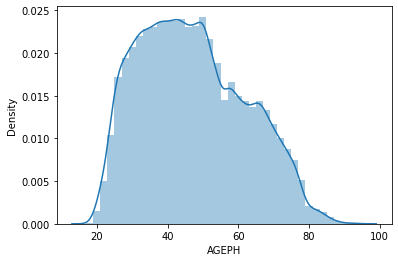

In [15]:
sns.distplot(df['AGEPH'], bins=39)

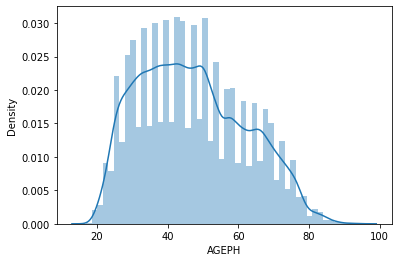

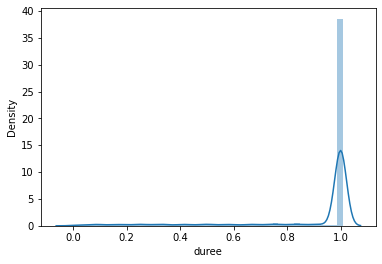

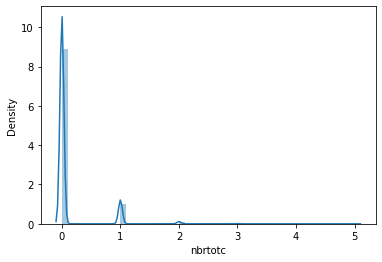

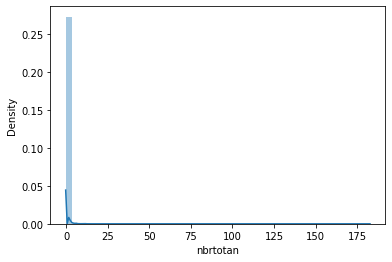

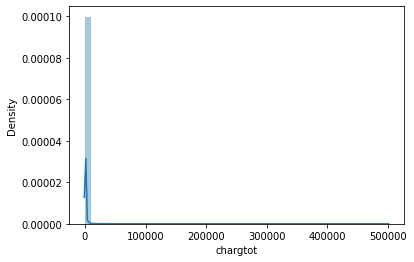

In [16]:
plot_univariate_numerical_variables_distribution(df, numerical_variables, params)

In [17]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot
AGEPH,1.000000,0.099901,0.078857,-0.069035,-0.038769,-0.016983
duree,0.099901,1.000000,0.913371,0.052203,-0.068061,0.000247
lnexpo,0.078857,0.913371,1.000000,0.056768,-0.081085,0.002479
nbrtotc,-0.069035,0.052203,0.056768,1.000000,0.471175,0.164385
nbrtotan,-0.038769,-0.068061,-0.081085,0.471175,1.000000,0.097633
chargtot,-0.016983,0.000247,0.002479,0.164385,0.097633,1.000000


We notice that `nbrtotc` and `nbrtotan` are highly correlated (the same goes for `duree` and `lnexpo`)

## 1.2 univariate analysis of categorical data <a name="one-two"></a>

In [18]:
categorical_variables = list(df.select_dtypes(include=['object']).columns)
categorical_variables

['CODPOSS',
 'agecar',
 'sexp',
 'fuelc',
 'split',
 'usec',
 'fleetc',
 'sportc',
 'coverp',
 'powerc']

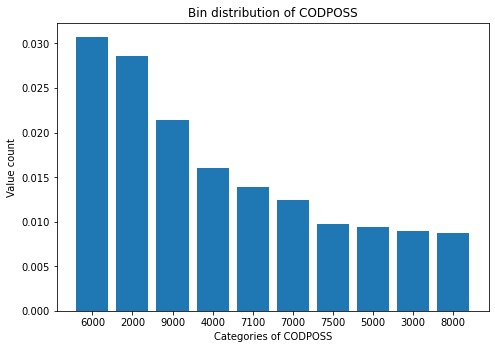

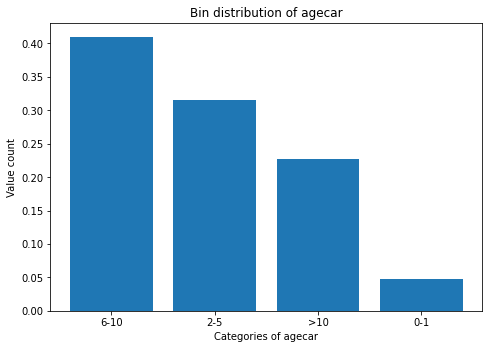

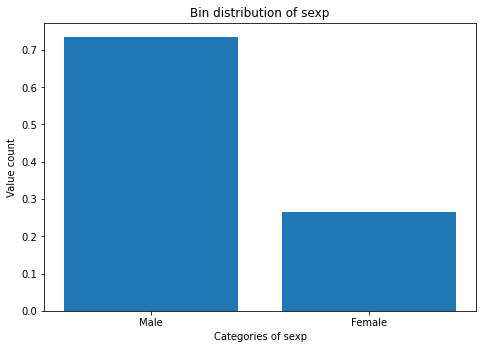

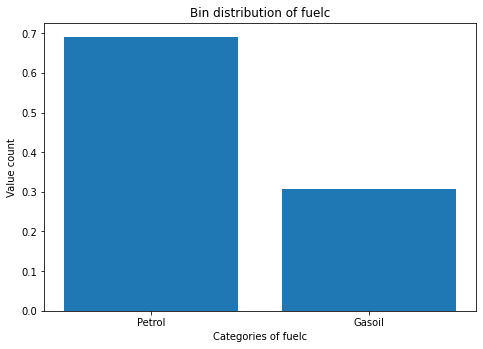

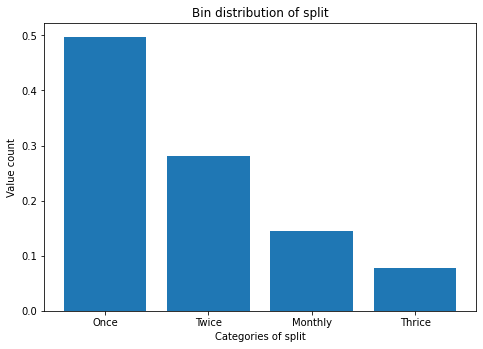

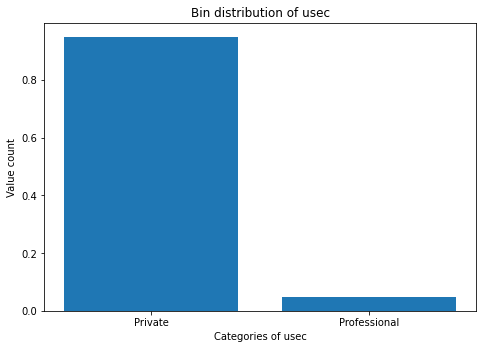

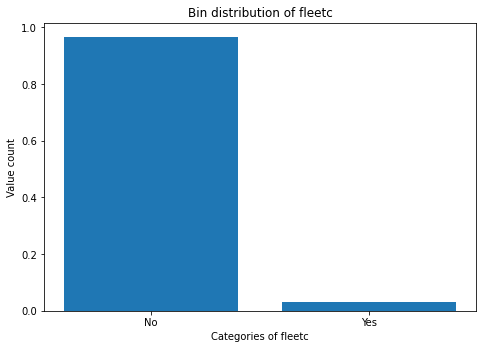

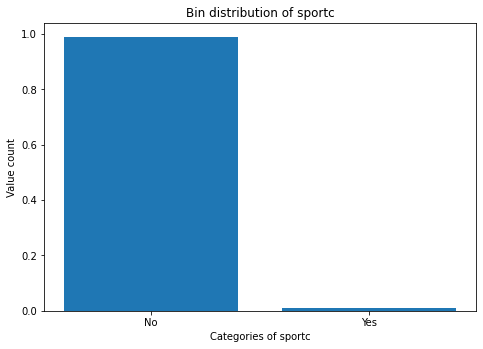

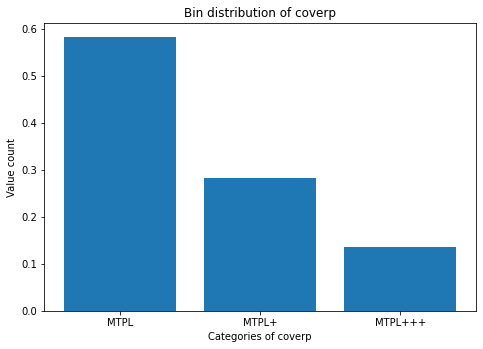

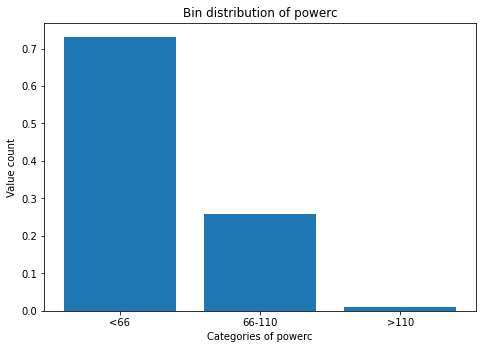

In [19]:
plot_univariate_categorical_variables_distribution(df, categorical_variables, params)

## 1.3 bivariate analysis of numerical data <a name="one-three"></a>

In [20]:
df[claim_frequency_name] = df[nb_claims_name]/df[exposure_name]

In [21]:
df[[claim_frequency_name, exposure_name, nb_claims_name, claim_amount_name]].describe()

,claim_frequency,duree,nbrtotc,chargtot
count,"163,657.00","163,657.00","163,657.00","163,657.00"
mean,0.16,0.89,0.12,192.00
std,0.98,0.24,0.37,"3,461.47"
min,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00
50%,0.00,1.00,0.00,0.00
75%,0.00,1.00,0.00,0.00
max,182.50,1.01,5.00,"500,000.00"


In [22]:
df.groupby(nb_claims_name)[nb_claims_name, exposure_name, claim_frequency_name].agg(nb_claims=(nb_claims_name, 'count'),\
                                                                                    exposure=(exposure_name, 'sum'),\
                                                                                    frequency=(claim_frequency_name, 'mean'))

,nb_claims,exposure,frequency
nbrtotc,,,
0,145312,"128,595.95",0.00
1,16602,"15,410.32",1.29
2,1562,"1,447.30",2.35
3,162,150.45,3.40
4,17,14.33,5.12
5,2,1.38,7.70


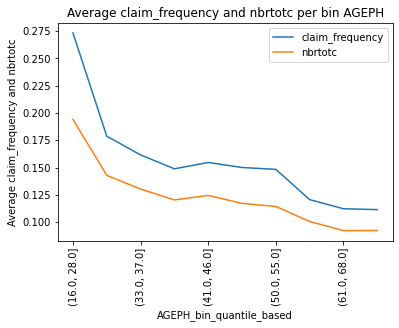

In [23]:
plot_avg_target_per_numerical_bin(df, ['AGEPH'], params, target=claim_frequency_name)

**Some observations:**

- The variable `AGEPH` is almost monotonically decreasing, we observe a small bump between 41 and 55 yo.

In [24]:
get_avg_target_per_numerical_bin(df, 'AGEPH', [nb_claims_name, claim_amount_name])

,nbrtotc,chargtot
AGEPH_bin_quantile_based,,
"(16.0, 28.0]",0.19,364.28
"(28.0, 33.0]",0.14,242.43
"(33.0, 37.0]",0.13,159.98
"(37.0, 41.0]",0.12,200.21
"(41.0, 46.0]",0.12,222.06
"(46.0, 50.0]",0.12,182.90
"(50.0, 55.0]",0.11,148.41
"(55.0, 61.0]",0.10,120.31
"(61.0, 68.0]",0.09,112.86


## 1.4 bivariate analysis of categorical data <a name="one-four"></a>

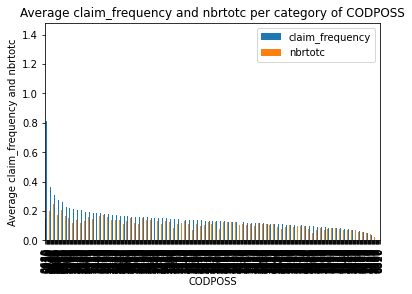

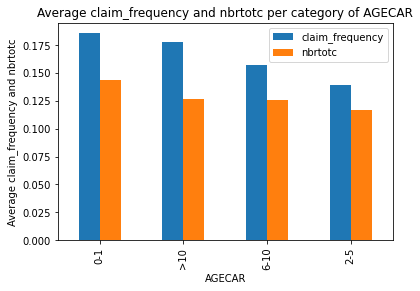

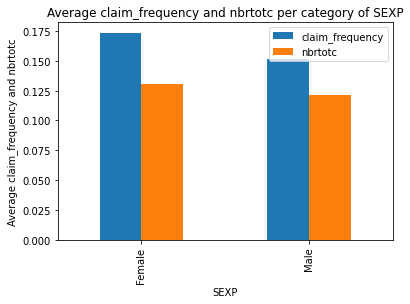

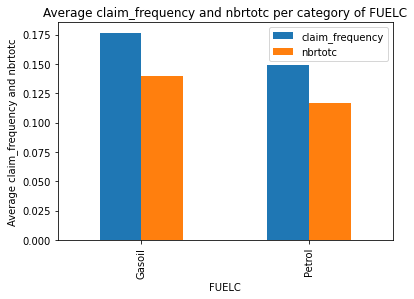

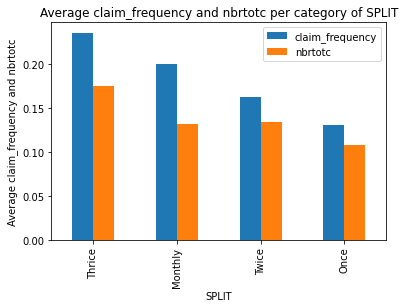

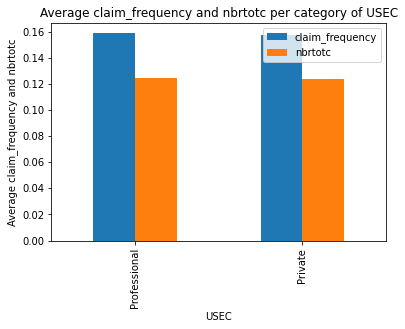

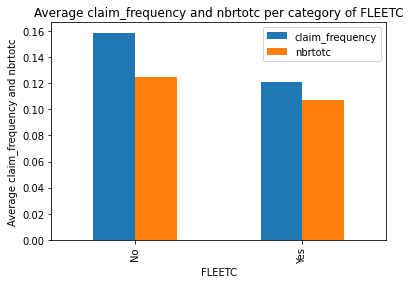

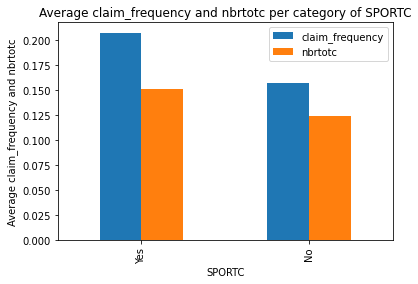

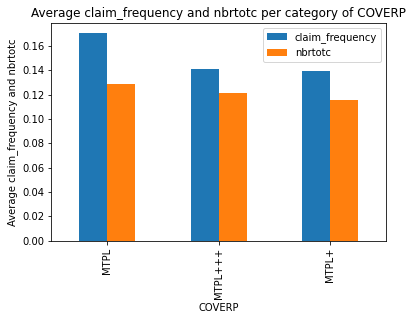

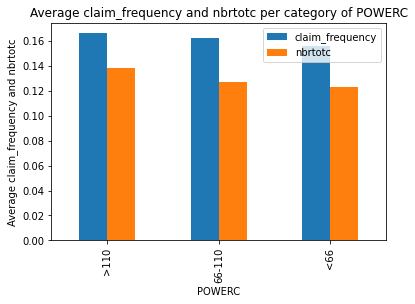

In [25]:
plt_avg_target_per_category(df, categorical_variables, params, target=claim_frequency_name)

**Some observations:**

- Difficult to interpret anything based on the `CODPOSS`, later on we will try to map this data to district information 
- `AGECAR`: it looks like it has a slight monotonic decreasing relationship between the claim frequency and `AGECAR`
- `SEXP_female` is slightly riskier group than `SEXP_male` when took alone.
- `FUELC_petrol` is slightly less risky group than `FUELC_gasoil` when took alone.
- `SPLIT`: Policyholders who pay their coverage by Thrice are riskier tham the Once.
- `USEC`: Professional and Private use do not seem to be significantly different.
- `FLEETC`: The fleet group is less risky.
- `SPORTC`: The sport group is riskier.
- `COVERP`: difficult to draw any conclusions.
- `POWERC`: It looks like the more power, the riskier although it is not absolutely clear.

In [26]:
for cat_var in categorical_variables:
    print(df.groupby(cat_var)[[claim_frequency_name,nb_claims_name, claim_amount_name]].mean().sort_values(by=[nb_claims_name, claim_amount_name], ascending=False))
    print('-'*100)

         claim_frequency  nbrtotc  chargtot
CODPOSS                                    
6637                0.33     0.30     46.71
1210                0.45     0.29    285.30
1040                0.34     0.25    453.85
3040                0.37     0.25    333.48
3790                0.32     0.25    240.45
...                  ...      ...       ...
6887                0.00     0.00      0.00
6890                0.00     0.00      0.00
6970                0.00     0.00      0.00
8920                0.00     0.00      0.00
8957                0.00     0.00      0.00

[583 rows x 3 columns]
----------------------------------------------------------------------------------------------------
        claim_frequency  nbrtotc  chargtot
agecar                                    
0-1                0.19     0.14    254.40
>10                0.18     0.13    201.37
6-10               0.16     0.13    197.88
2-5                0.14     0.12    168.18
---------------------------------------------

In [27]:
# processing postcode data
postcode_mapping = pd.read_csv(params.get(Constants.LINK_TO_POSTAL_CODE_MAPPING), delimiter=';')
postcode_mapping.head(3)

,Code,Localite,Longitude,Latitude,Coordonnees,Geom
0,1050,Ixelles,4.38,50.82,"50.8222854,4.3815707",NaN
1,1081,Koekelberg,4.33,50.86,"50.8622633,4.3257084",NaN
2,1130,Haren,4.41,50.89,"50.8919661,4.41257087324",NaN


In [28]:
postcode_mapping['Code'] = postcode_mapping['Code'].astype('str')

In [29]:
postcode_mapping_dic = {}
for code, district in zip(postcode_mapping.Code, postcode_mapping.Localite):
    if code not in postcode_mapping:
        postcode_mapping_dic[code]= district

In [30]:
df['district'] = df.CODPOSS.replace(postcode_mapping_dic)

In [31]:
avg_claim_per_district = df.groupby('district')[[claim_frequency_name,nb_claims_name, claim_amount_name]].mean().sort_values(by=[claim_frequency_name, claim_amount_name], ascending=False)

Text(0, 0.5, 'claim frequency')

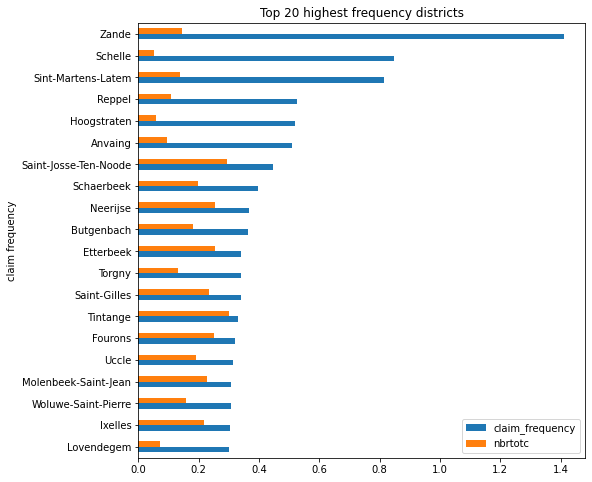

In [32]:
avg_claim_per_district.head(20)[[claim_frequency_name, nb_claims_name]].sort_values(by=claim_frequency_name).plot.barh(figsize=(8,8))
plt.title('Top 20 highest frequency districts')
plt.ylabel('claim frequency')

A lot of riskier district are from **Bruxelles** (ex: Sint-Josse, Schaerbeek, Etterbeek, Saint-Gilles, Uccle, Molenbeek, Woluwe, Ixelles)

Text(0, 0.5, 'claim frequency')

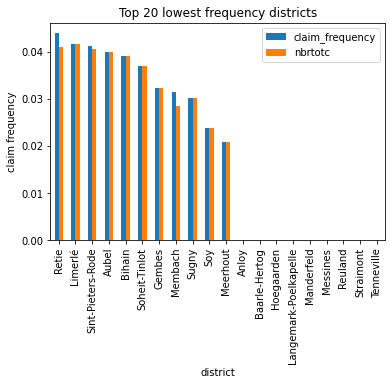

In [33]:
avg_claim_per_district.tail(20)[[claim_frequency_name, nb_claims_name]].plot.bar()
plt.title('Top 20 lowest frequency districts')
plt.ylabel('claim frequency')

In [34]:
#TODO: check the interactions between variables (probably interaction between age and sex and other properties of the car)

# 2. Feature Engineering <a name="two"></a>

We decide to work only with categorical variables in order for faciliate the interpretation. 

In [35]:
for cat_var in categorical_variables:
    df[cat_var] = pd.Categorical(df[cat_var])
for num_var in numerical_variables:
    df[num_var] = pd.to_numeric(df[num_var])

In [36]:
df, risk_group_mapping = apply_mean_hot_categorical_encoding(df, 
                                                             claim_frequency_name, 
                                                             'district', nb_bin=3) 
#, risk_groups = ['A', 'B', 'C', 'D', 'E'])

In order to reduce the dimensionality, we proceed to a **mean-hot categorical encoding**. Based on the claim frequency, we want create three categories *high*, *medium* and *low* risk groups.

In [37]:
for i,(district, risk_group) in enumerate(risk_group_mapping.items()):
    if i >20:
        break
    print(f'{district} ---> {risk_group}')
        

's Gravenwezel ---> high
Aalst ---> high
Aartselaar ---> medium
Aiseau ---> medium
Alken ---> medium
Alveringem ---> high
Anderlecht ---> high
Anderlues ---> medium
Anloy ---> low
Ans ---> medium
Anthisnes ---> low
Anthée ---> low
Antoing ---> low
Antwerpen ---> high
Anvaing ---> high
Arbrefontaine ---> medium
Ardooie ---> medium
Arendonk ---> low
As ---> high
Assenede ---> low
Assent ---> medium


In order for our algorithm/model to correctly read the information we feed it, the data needs to be numerically encoded. To keep things simple, suppose we had a vector of the age of policyholder as follow with minimum and maximum age going from 0 to 100:

age = (90, 20, 30, 60, 79)

We apply quantile binning method such that such vector will be transformed in such a matrice:


In [38]:
age_transformed = pd.DataFrame.from_dict({'[0-20)':[0,0,0,0,0],
                                          '[20-40)':[0, 1, 1, 0,0],
                                        '[40-60)':[0,0,0,0,0],
                                        '[60-80)':[0,0,0,1,1],
                                        '[80-100]':[1,0,0,0,0]})

In [39]:
age_transformed.index = [90, 20, 30, 60, 79]

In [40]:
age_transformed

,[0-20),[20-40),[40-60),[60-80),[80-100]
90,0,0,0,0,1
20,0,1,0,0,0
30,0,1,0,0,0
60,0,0,0,1,0
79,0,0,0,1,0


In [41]:
df = bin_numerical_variables(df, 'AGEPH', nb_bin=5)

In [42]:
df.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,claim_frequency,district,district_risk_group,AGEPH_bin
0,64,1000,1.00,0.00,0,0.00,0.00,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,0.00,Bruxelles,high,"(61.0, 95.0]"
1,28,1000,0.05,-3.07,1,21.47,155.97,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21.47,Bruxelles,high,"(16.999, 33.0]"
2,58,1000,0.40,-0.91,0,0.00,0.00,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,0.00,Bruxelles,high,"(50.0, 61.0]"
3,37,1030,0.17,-1.77,0,0.00,0.00,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110,0.00,Schaerbeek,high,"(33.0, 41.0]"
4,29,1030,1.00,0.00,0,0.00,0.00,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66,0.00,Schaerbeek,high,"(16.999, 33.0]"


In [43]:
df.dtypes

AGEPH                     int64
CODPOSS                category
duree                   float64
lnexpo                  float64
nbrtotc                   int64
nbrtotan                float64
chargtot                float64
agecar                 category
sexp                   category
fuelc                  category
split                  category
usec                   category
fleetc                 category
sportc                 category
coverp                 category
powerc                 category
claim_frequency         float64
district                 object
district_risk_group    category
AGEPH_bin              category
dtype: object

## 2.1 Processing with Binning continuous variables <a name="two-one"></a>

In [44]:
test_size, random_state = params.get(Constants.TEST_SIZE), params.get(Constants.RANDOM_STATE)

In [45]:
df_cp = df.copy()

In [46]:
df.columns

Index(['AGEPH', 'CODPOSS', 'duree', 'lnexpo', 'nbrtotc', 'nbrtotan',
       'chargtot', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc',
       'sportc', 'coverp', 'powerc', 'claim_frequency', 'district',
       'district_risk_group', 'AGEPH_bin'],
      dtype='object')

In [47]:
#nb_claims, claim_amount, claim_frequency = df[nb_claims_name], df[claim_amount_name], df[claim_frequency_name]
#exposure = df[exposure_name]

In [48]:
non_predictor_variables = [
                         #claim_amount_name, \
                         #  claim_frequency_name, \
                      #     nb_claims_name,
                           'nbrtotan',
                           'district',
                           'CODPOSS',
                            'AGEPH',
                           *params.get(Constants.VARIABLES_TO_EXCLUDE)]

In [49]:
df_step1 =df.drop(columns=non_predictor_variables)

In [50]:
df_step1.columns

Index(['duree', 'nbrtotc', 'chargtot', 'agecar', 'sexp', 'fuelc', 'split',
       'usec', 'fleetc', 'sportc', 'coverp', 'powerc', 'claim_frequency',
       'district_risk_group', 'AGEPH_bin'],
      dtype='object')

In [51]:
df_step1.dtypes

duree                   float64
nbrtotc                   int64
chargtot                float64
agecar                 category
sexp                   category
fuelc                  category
split                  category
usec                   category
fleetc                 category
sportc                 category
coverp                 category
powerc                 category
claim_frequency         float64
district_risk_group    category
AGEPH_bin              category
dtype: object

In [52]:
get_distribution_info_for_categorical_variables(df_step1)

,nb_unique_categories,distribution
agecar,4,"{'6-10': '41.03%', '2-5': '31.50%', '>10': '22.72%', '0-1': '4.75%'}"
sexp,2,"{'Male': '73.59%', 'Female': '26.41%'}"
fuelc,2,"{'Petrol': '69.18%', 'Gasoil': '30.82%'}"
split,4,"{'Once': '49.79%', 'Twice': '28.08%', 'Monthly': '14.42%', 'Thrice': '7.71%'}"
usec,2,"{'Private': '95.11%', 'Professional': '4.89%'}"
fleetc,2,"{'No': '96.80%', 'Yes': '3.20%'}"
sportc,2,"{'No': '99.08%', 'Yes': '0.92%'}"
coverp,3,"{'MTPL': '58.30%', 'MTPL+': '28.15%', 'MTPL+++': '13.55%'}"
powerc,3,"{'<66': '73.21%', '66-110': '25.78%', '>110': '1.01%'}"
district_risk_group,3,"{'high': '45.56%', 'medium': '35.31%', 'low': '19.13%'}"


In [53]:
df_step1

,duree,nbrtotc,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,claim_frequency,district_risk_group,AGEPH_bin
0,1.00,0,0.00,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,0.00,high,"(61.0, 95.0]"
1,0.05,1,155.97,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21.47,high,"(16.999, 33.0]"
2,0.40,0,0.00,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,0.00,high,"(50.0, 61.0]"
3,0.17,0,0.00,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110,0.00,high,"(33.0, 41.0]"
4,1.00,0,0.00,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66,0.00,high,"(16.999, 33.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,1.00,0,0.00,2-5,Male,Petrol,Once,Private,No,No,MTPL+,<66,0.00,low,"(41.0, 50.0]"
163653,1.00,0,0.00,6-10,Male,Petrol,Once,Private,No,No,MTPL,<66,0.00,low,"(61.0, 95.0]"
163654,1.00,0,0.00,2-5,Male,Petrol,Twice,Private,No,No,MTPL,<66,0.00,low,"(61.0, 95.0]"
163655,1.00,1,"3,177.99",>10,Male,Petrol,Once,Private,Yes,No,MTPL,<66,1.00,low,"(50.0, 61.0]"


### 2.1.1 Dummy Coding with reference class <a name="two-one-one"></a>

One-hot encoding works as follow suppose you have a vector of information as follow

genders = (Male, Female, Female, Female, Male)

Now, suppose the male group is less risky (like this is the case in this dataset, in terms of average claim frequency), we will decide to take out the gender_male variable from the dataset as it constitutes a reference class. 

We will end up with a transformation of our gender vector as follow:


In [54]:
genders_transformed = pd.DataFrame.from_dict({'gender_male':[1, 0,0,0,1],
                                              'gender_female':[0,1,1,1,0],
                                             })
genders_transformed.index=['Male', 'Female', 'Female', 'Female', 'Male']

In [55]:
pd.DataFrame(genders_transformed.loc[:, 'gender_female'])

,gender_female
Male,0
Female,1
Female,1
Female,1
Male,0


In [56]:
df_step1_dummy = pd.get_dummies(df_step1)

In [57]:
df_step1_dummy.shape

(163657, 36)

In [58]:
reference_class_lst = get_reference_classes(df_step1, nb_claims_name, exposure_name)

The reference class of agecar is 2-5
The reference class of sexp is Male
The reference class of fuelc is Petrol
The reference class of split is Once
The reference class of usec is Private
The reference class of fleetc is Yes
The reference class of sportc is No
The reference class of coverp is MTPL+
The reference class of powerc is <66
The reference class of district_risk_group is low
The reference class of AGEPH_bin is (61.0, 95.0]


In [59]:
reference_class_sev_lst = get_reference_classes(df_step1, claim_amount_name, valid_for_severity=True)

The reference class of agecar is 2-5
The reference class of sexp is Male
The reference class of fuelc is Petrol
The reference class of split is Twice
The reference class of usec is Professional
The reference class of fleetc is Yes
The reference class of sportc is No
The reference class of coverp is MTPL+
The reference class of powerc is <66
The reference class of district_risk_group is low
The reference class of AGEPH_bin is (61.0, 95.0]


The policyholder belonging to all those classes is the less risky

As we have been encoding our variables $x_{ij}s$ as binary variables.

$\beta_{0}$ is the risk related to the reference class.

According to the Poisson regression model defined above, the annual claim frequency $\lambda_{i}$ associated with $x_{i}$ is of multiplicative form:

$\lambda_{i} = exp(\beta_{0}) \prod_{j|x_{ij}=1}exp(\beta_{j})$

-  $exp(\beta_{0})$ is the annual claim frequency associated with the reference class
- $exp(\beta_{j})$ models the impact of the jth variable

In [60]:
reference_class_lst

['agecar_2-5',
 'sexp_Male',
 'fuelc_Petrol',
 'split_Once',
 'usec_Private',
 'fleetc_Yes',
 'sportc_No',
 'coverp_MTPL+',
 'powerc_<66',
 'district_risk_group_low',
 'AGEPH_bin_(61.0, 95.0]']

In [61]:
df_step1_dummy.head(3)

,duree,nbrtotc,chargtot,claim_frequency,agecar_0-1,agecar_2-5,agecar_6-10,agecar_>10,sexp_Female,sexp_Male,...,powerc_<66,powerc_>110,district_risk_group_high,district_risk_group_low,district_risk_group_medium,"AGEPH_bin_(16.999, 33.0]","AGEPH_bin_(33.0, 41.0]","AGEPH_bin_(41.0, 50.0]","AGEPH_bin_(50.0, 61.0]","AGEPH_bin_(61.0, 95.0]"
0,1.00,0,0.00,0.00,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0.05,1,155.97,21.47,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,0.40,0,0.00,0.00,0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,1,0


In [62]:
reference_class_lst

['agecar_2-5',
 'sexp_Male',
 'fuelc_Petrol',
 'split_Once',
 'usec_Private',
 'fleetc_Yes',
 'sportc_No',
 'coverp_MTPL+',
 'powerc_<66',
 'district_risk_group_low',
 'AGEPH_bin_(61.0, 95.0]']

In [63]:
DATASET = df_step1_dummy.drop(columns=reference_class_lst)
DATASET_SEV = df_step1_dummy.drop(columns=reference_class_sev_lst)

In [64]:
DATASET.shape == (df_step1_dummy.shape[0], df_step1_dummy.shape[1] -len(reference_class_lst))

True

In [65]:
DATASET.rename(columns=params.get(Constants.RENAMING_DUMMY_CODING_MAPPING), inplace=True)
DATASET_SEV.rename(columns=params.get(Constants.RENAMING_DUMMY_CODING_MAPPING), inplace=True)

In [66]:
DATASET.head(3)

,duree,nbrtotc,chargtot,claim_frequency,agecar_zero_one,agecar_six_ten,agecar_higher_ten,sexp_Female,fuelc_Gasoil,split_Monthly,...,coverp_MTPL,coverp_MTPLplusplusplus,powerc_sixtysix_onehundredten,powerc_higher_onehundredten,district_risk_group_high,district_risk_group_medium,AGEPH_bin_seventeen_thirtythree,AGEPH_bin_thirtythree_forty_one,AGEPH_bin_forty_one_fifty,AGEPH_bin_fifty_sixty_one
0,1.00,0,0.00,0.00,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0.05,1,155.97,21.47,0,1,0,1,0,0,...,1,0,1,0,1,0,1,0,0,0
2,0.40,0,0.00,0.00,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1


In [67]:
claim_frequency, claim_amount = DATASET[claim_frequency_name], DATASET[claim_amount_name]
X = DATASET.drop(columns=[claim_frequency_name, claim_amount_name])
X_sev = DATASET_SEV.drop(columns=[claim_frequency_name, nb_claims_name])

# 3. Modelling <a name="three"></a>

For each policyholder $i$, we can identify the 

- $N_{i}$, the number of claims during the period/exposure $d_{i}$ (the duration over which the contract is force)
- $L_{i}$, the aggregate loss related to $N_{i}$ claims

The pure premium or risk premium is often denoted as $\pi_{i}$ and broken down as follow:

$\pi_{i}$ = $\mathbb{E}[\frac{N_{i}}{d_{i}}]. \mathbb{E}[\frac{L_{i}}{N_{i}}|N_{i} > 0] = \underbrace{\mathbb{E}[F_{i}]}_\text{frequency}.\underbrace{\mathbb{E}[Sev_{i}]}_\text{severity}$
***

Let set $\mathbf{x_{i}} = (x_{i1}, \cdots , x_{ip})'$

$\mathbb{E}[N_{i} | \mathbf{x_{i}}] = d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

$N_{i} \sim Poi(d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

***

The score of the linear predictor is defined as follow:
    
$score_{i} = \beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})$

The expected claim frequency for policyholder $i$ is: $d_{i}exp(score_{i})$

$\hat{\beta_{0}}, \hat{\beta_{1}}, \cdots, \hat{\beta_{p}}$  are the estimates of the regression coefficients $\beta_{0}, \beta_{1}, \cdots, \beta_{p} $

$\hat{\lambda_{i}} = d_{i}exp(\hat{score_{i}})$

$\hat{\lambda_{i}} = d_{i}exp(\hat{\beta_{0}} + \sum_{j=1}^{p}(\hat{\beta_{j}}x_{ij}))$

is the predicted number of claims for policyholder $i$

## 3.1 Regression Tree <a name="three-one"></a>

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, claim_frequency, 
                                                    test_size=test_size, 
                                                    random_state=random_state,
                                                   stratify=X[nb_claims_name])
exp_train, exp_test = x_train[exposure_name], x_test[exposure_name]


In [69]:
x_train = x_train.drop(columns=[nb_claims_name, exposure_name])
x_test = x_test.drop(columns=[nb_claims_name, exposure_name])

In [70]:
poisson_tree = DecisionTreeRegressor(criterion='poisson',max_depth=3, ccp_alpha=0)
poisson_tree.fit(x_train, y_train, sample_weight=exp_train)

DecisionTreeRegressor(ccp_alpha=0, criterion='poisson', max_depth=3)

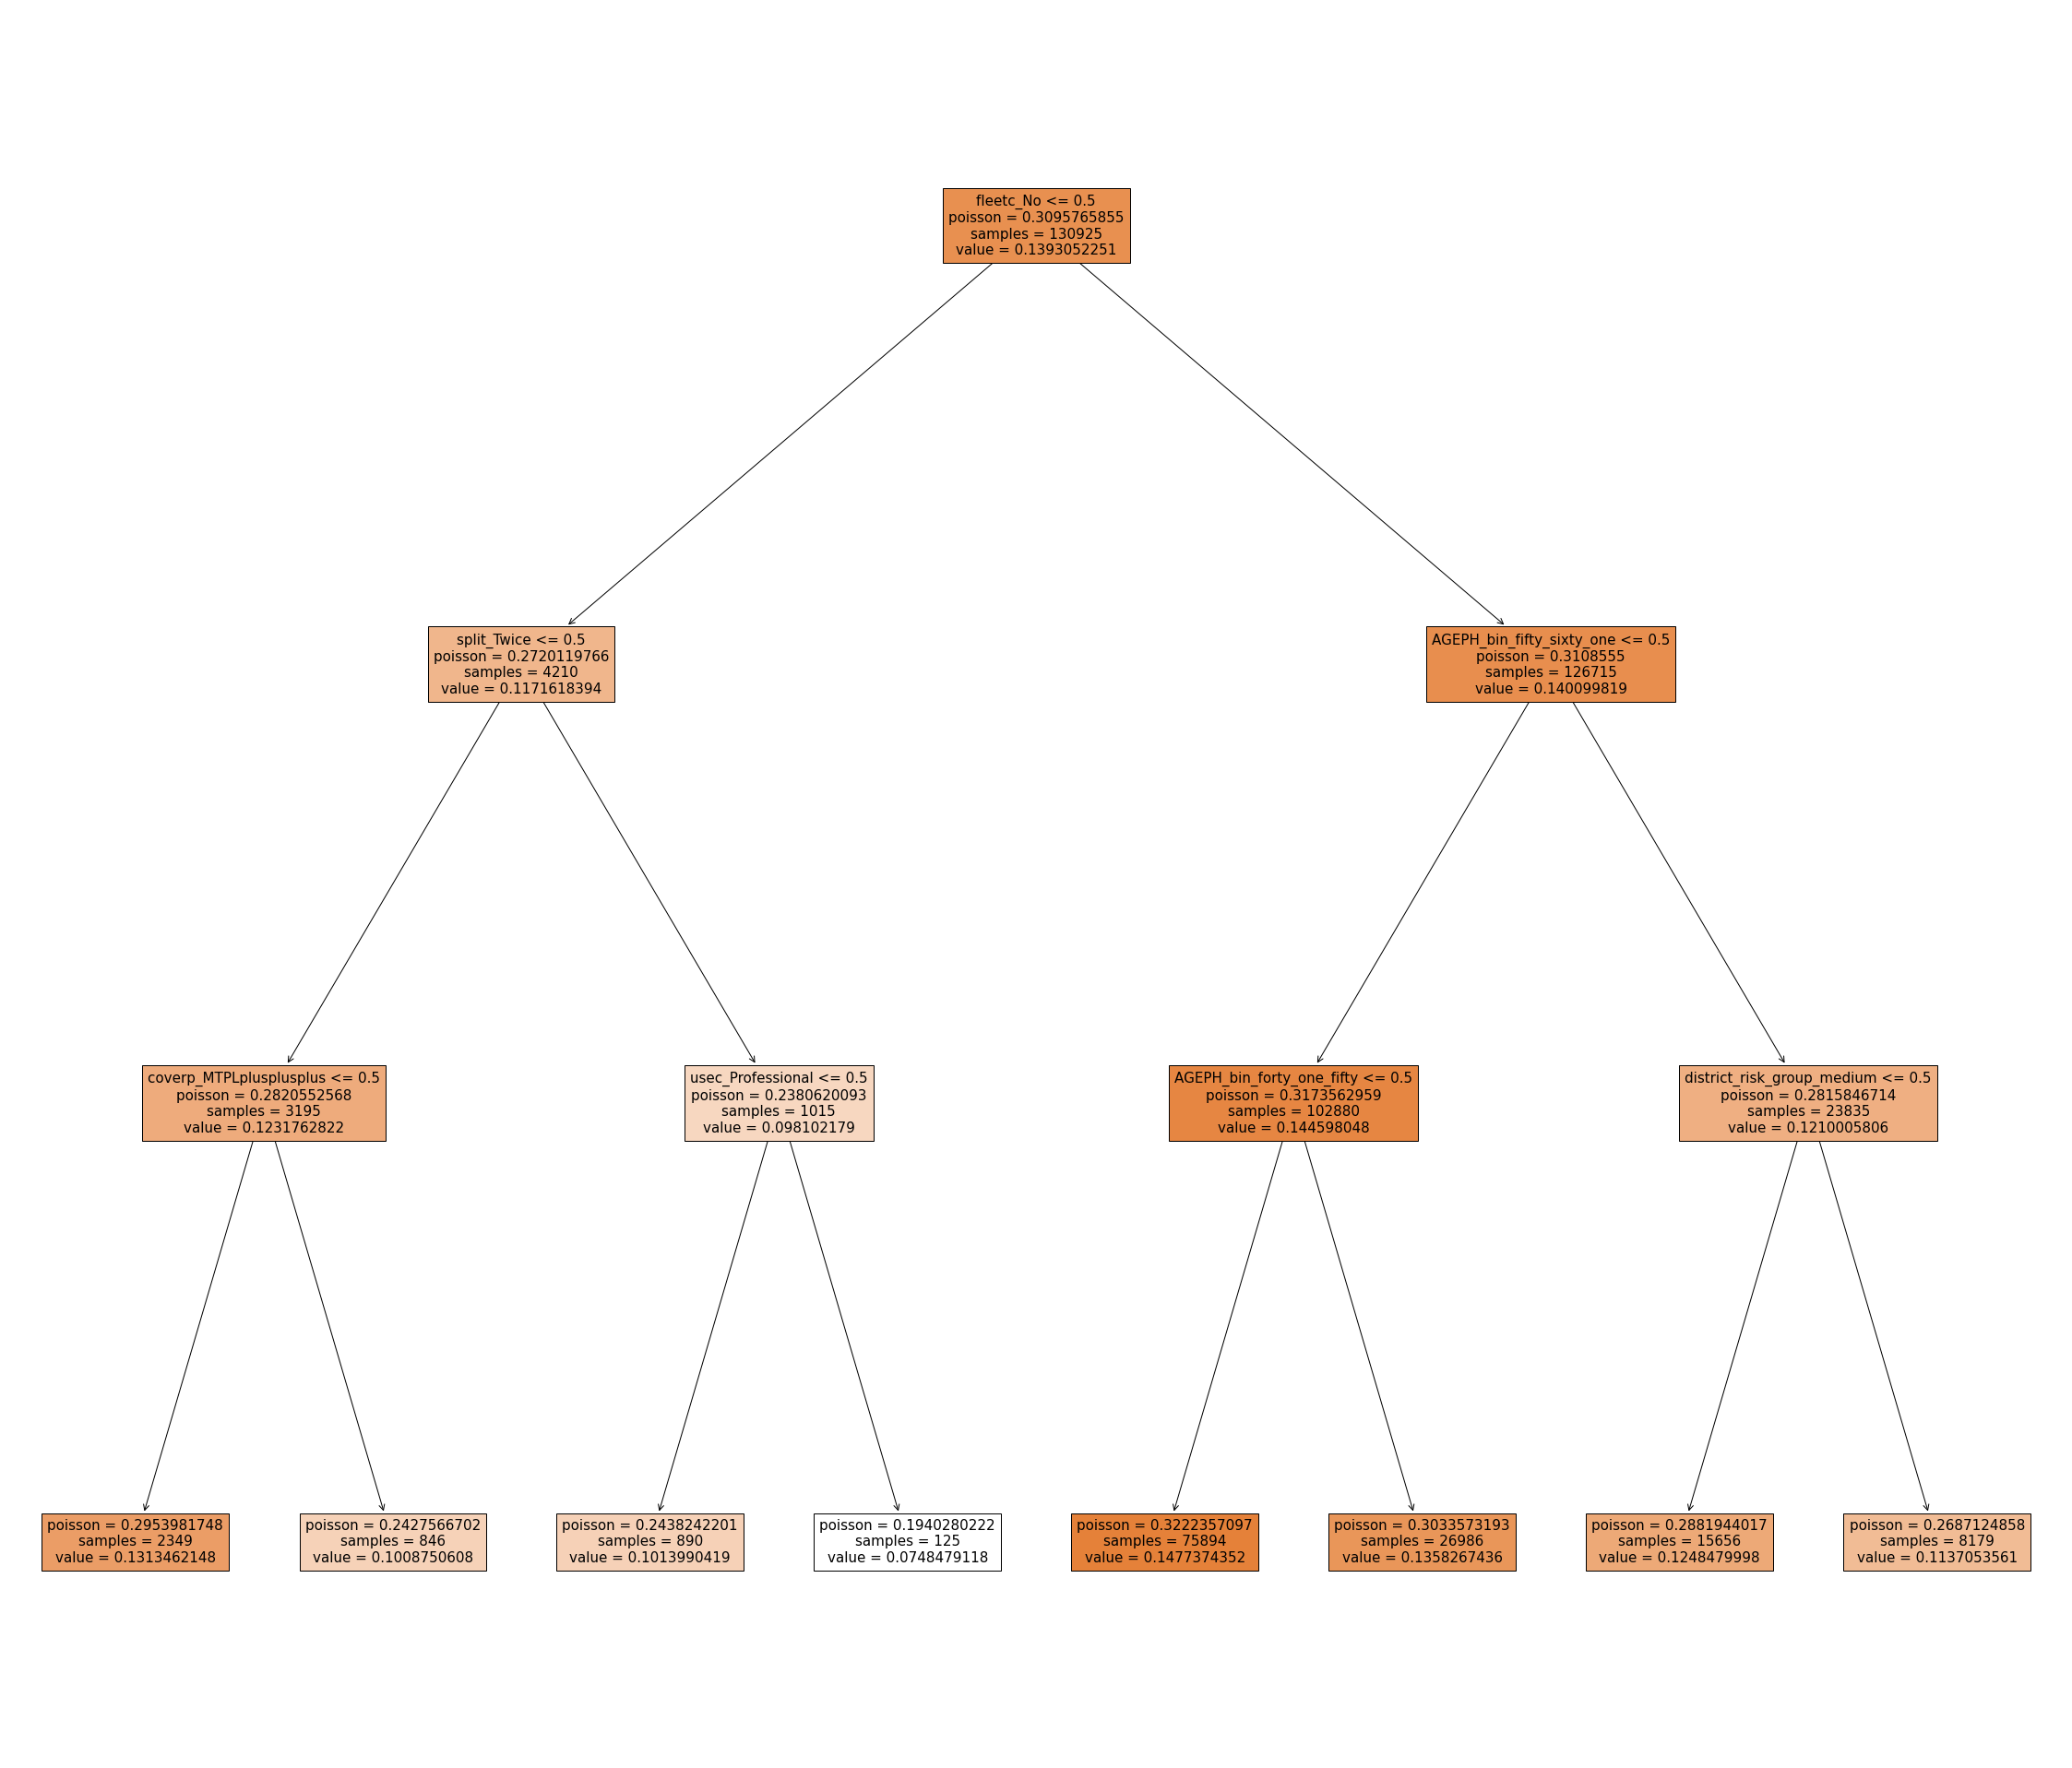

In [71]:
fig = plt.figure(figsize=(40,35))
_=tree.plot_tree(poisson_tree, 
                   feature_names=x_train.columns,  
                   filled=True,
                precision=10)

In [72]:
#viz = dtreeviz(poisson_tree, x_train, y_train,
#                target_name=claim_frequency_name,
 #               feature_names=list(x_train.columns))
#viz.save("decision_tree.svg")

In [73]:
list(enumerate(x_train.columns))

[(0, 'agecar_zero_one'),
 (1, 'agecar_six_ten'),
 (2, 'agecar_higher_ten'),
 (3, 'sexp_Female'),
 (4, 'fuelc_Gasoil'),
 (5, 'split_Monthly'),
 (6, 'split_Thrice'),
 (7, 'split_Twice'),
 (8, 'usec_Professional'),
 (9, 'fleetc_No'),
 (10, 'sportc_Yes'),
 (11, 'coverp_MTPL'),
 (12, 'coverp_MTPLplusplusplus'),
 (13, 'powerc_sixtysix_onehundredten'),
 (14, 'powerc_higher_onehundredten'),
 (15, 'district_risk_group_high'),
 (16, 'district_risk_group_medium'),
 (17, 'AGEPH_bin_seventeen_thirtythree'),
 (18, 'AGEPH_bin_thirtythree_forty_one'),
 (19, 'AGEPH_bin_forty_one_fifty'),
 (20, 'AGEPH_bin_fifty_sixty_one')]

In [74]:
print(tree.export_text(poisson_tree))

|--- feature_9 <= 0.50
|   |--- feature_7 <= 0.50
|   |   |--- feature_12 <= 0.50
|   |   |   |--- value: [0.13]
|   |   |--- feature_12 >  0.50
|   |   |   |--- value: [0.10]
|   |--- feature_7 >  0.50
|   |   |--- feature_8 <= 0.50
|   |   |   |--- value: [0.10]
|   |   |--- feature_8 >  0.50
|   |   |   |--- value: [0.07]
|--- feature_9 >  0.50
|   |--- feature_20 <= 0.50
|   |   |--- feature_19 <= 0.50
|   |   |   |--- value: [0.15]
|   |   |--- feature_19 >  0.50
|   |   |   |--- value: [0.14]
|   |--- feature_20 >  0.50
|   |   |--- feature_16 <= 0.50
|   |   |   |--- value: [0.12]
|   |   |--- feature_16 >  0.50
|   |   |   |--- value: [0.11]



In [75]:
feature_importances = dict()
for feature, importance in zip(x_train.columns, poisson_tree.feature_importances_):
    feature_importances[feature] = importance

In [76]:
feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
feature_importances_df.rename(columns={0:'importance'}, inplace=True)

Text(0.5, 0, 'Sum of reduced deviance imduced by a feature splits')

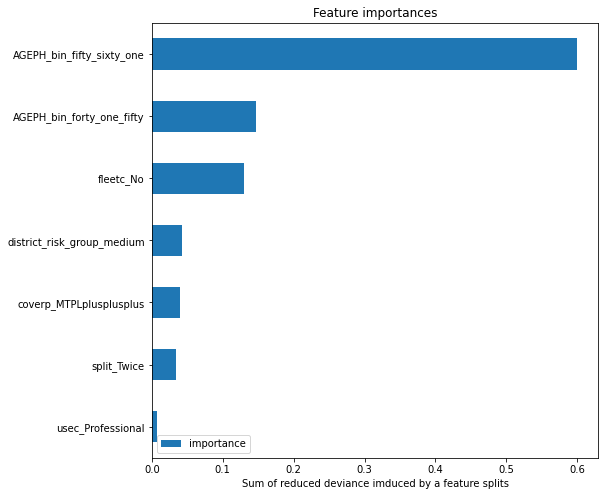

In [77]:
feature_importances_df.query('importance>0').sort_values(by='importance').plot.barh(figsize=(8,8))
plt.title('Feature importances')
plt.xlabel('Sum of reduced deviance imduced by a feature splits')

In [78]:
#hyperopt on max_tree_depth and ccp_alpha

In [79]:
results = {}

In [80]:
dev_poiss_tree_train = mean_poisson_deviance(y_train, poisson_tree.predict(x_train),sample_weight=exp_train)
dev_poiss_tree_test = mean_poisson_deviance(y_test, poisson_tree.predict(x_test),sample_weight=exp_test)
results['dev_poiss_tree_train'] = dev_poiss_tree_train
results['dev_poiss_tree_test'] = dev_poiss_tree_test

In [81]:
results

{'dev_poiss_tree_train': 0.6181288519544759,
 'dev_poiss_tree_test': 0.6183133528786787}

In [82]:
#info_input = np.flip(x_train.loc[0,:].values.reshape(1, x_train.shape[1]))
#dec_path = poisson_tree.decision_path(info_input)

In [83]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [125]:
step = 0.05
param_grid = {'max_depth': list(np.arange(3,8)),
               'random_state':[random_state],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,1+step, step))}
mean_poisson_dev_with_weights = partial(mean_poisson_deviance, sample_weight=exp_train)

In [126]:
from functools import partial

In [127]:
mean_poisson_dev_with_weights = partial(mean_poisson_deviance, sample_weight=exp_train)

In [128]:
tree_reg = RandomizedSearchCV(DecisionTreeRegressor(), 
                              param_distributions=param_grid, 
                              n_iter=100,
                              scoring=mean_poisson_dev_with_weights)

In [129]:
tree_reg.fit(x_train, y_train, sample_weight=exp_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=100,
                   param_distributions={'ccp_alpha': [0.0, 0.05, 0.1,
                                                      0.15000000000000002, 0.2,
                                                      0.25, 0.30000000000000004,
                                                      0.35000000000000003, 0.4,
                                                      0.45, 0.5, 0.55,
                                                      0.6000000000000001, 0.65,
                                                      0.7000000000000001, 0.75,
                                                      0.8, 0.8500000000000001,
                                                      0.9, 0.9500000000000001,
                                                      1.0],
                                        'criterion': ['poisson'],
                                        'max_depth': [3, 4, 5, 6, 7],
                                      

In [131]:
tree_reg.best_params_

{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.65}

In [132]:
pd.DataFrame.from_dict(tree_reg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_max_depth,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.12,0.01,0.00,0.00,42,7,poisson,0.65,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.65}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.10,0.01,0.00,0.00,42,6,poisson,0.05,"{'random_state': 42, 'max_depth': 6, 'criterion': 'poisson', 'ccp_alpha': 0.05}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,72
2,0.08,0.00,0.00,0.00,42,4,poisson,0.15,"{'random_state': 42, 'max_depth': 4, 'criterion': 'poisson', 'ccp_alpha': 0.15000000000000002}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,71
3,0.07,0.00,0.00,0.00,42,4,poisson,0.20,"{'random_state': 42, 'max_depth': 4, 'criterion': 'poisson', 'ccp_alpha': 0.2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
4,0.08,0.00,0.00,0.00,42,5,poisson,0.10,"{'random_state': 42, 'max_depth': 5, 'criterion': 'poisson', 'ccp_alpha': 0.1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.10,0.01,0.00,0.00,42,4,poisson,0.50,"{'random_state': 42, 'max_depth': 4, 'criterion': 'poisson', 'ccp_alpha': 0.5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
96,0.08,0.00,0.00,0.00,42,3,poisson,0.05,"{'random_state': 42, 'max_depth': 3, 'criterion': 'poisson', 'ccp_alpha': 0.05}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
97,0.08,0.00,0.00,0.00,42,3,poisson,0.30,"{'random_state': 42, 'max_depth': 3, 'criterion': 'poisson', 'ccp_alpha': 0.30000000000000004}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
98,0.14,0.01,0.00,0.00,42,7,poisson,0.00,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,87


It looks like the RandomGridSearch from scikit learn does not work when looking at the test scores

In [92]:
x_train

,agecar_zero_one,agecar_six_ten,agecar_higher_ten,sexp_Female,fuelc_Gasoil,split_Monthly,split_Thrice,split_Twice,usec_Professional,fleetc_No,...,coverp_MTPL,coverp_MTPLplusplusplus,powerc_sixtysix_onehundredten,powerc_higher_onehundredten,district_risk_group_high,district_risk_group_medium,AGEPH_bin_seventeen_thirtythree,AGEPH_bin_thirtythree_forty_one,AGEPH_bin_forty_one_fifty,AGEPH_bin_fifty_sixty_one
464,0,0,1,1,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
117265,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,1,0,0,0,0,0
22022,0,0,0,1,1,0,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
39909,1,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
144601,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116975,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
160389,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
32885,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
158901,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0


In [93]:
type(poisson_tree)

sklearn.tree._classes.DecisionTreeRegressor

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, claim_frequency, 
                                                    test_size=test_size, 
                                                    random_state=random_state,
                                                   stratify=X[nb_claims_name])
exp_train, exp_test = x_train[exposure_name], x_test[exposure_name]

x_train = x_train.drop(columns=[nb_claims_name, exposure_name])
x_test = x_test.drop(columns=[nb_claims_name, exposure_name])

poisson_tree = DecisionTreeRegressor(criterion='poisson',max_depth=3, ccp_alpha=0)
poisson_tree.fit(x_train, y_train, sample_weight=exp_train)

In [123]:
df_train = pd.concat([x_train, y_train, exp_train], axis=1)

In [98]:
from typing import *
import sklearn

In [ ]:
step = 0.05
param_grid = {'max_depth': list(np.arange(3,8)),
               'random_state':[random_state],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,1+step, step))}
mean_poisson_dev_with_weights = partial(mean_gamma_deviance, sample_weight=exp_train)

In [135]:
def fitting_regression_tree(params_model:Dict[str, Any], 
                            x_train:pd.DataFrame, 
                            y_train:Union[pd.Series, pd.DataFrame],
                            exp_train:Union[pd.Series, pd.DataFrame]) -> sklearn.tree._classes.DecisionTreeRegressor:
    
    poisson_tree = DecisionTreeRegressor(**params_model)
    poisson_tree.fit(x_train, y_train, sample_weight=exp_train)
    return poisson_tree

In [151]:
hyperparams_space = param_grid
model_fit_func = fitting_regression_tree
loss_function = mean_poisson_deviance
params_to_record = None
limit_time = 100
max_iter = 100
is_debug = False
params_to_record = ['ccp_alpha', 'max_depth']

In [ ]:
run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=True)

the number of the maximum iterations is 100
--------------------------------
1 iteration starting...
1.1920928955078125e-06 time elapsed...
--------------------------------
2 iteration starting...
0.5741581916809082 time elapsed...
--------------------------------
3 iteration starting...
1.6595721244812012 time elapsed...
--------------------------------
4 iteration starting...
2.3093600273132324 time elapsed...
--------------------------------
5 iteration starting...
3.218569040298462 time elapsed...
--------------------------------
6 iteration starting...
4.116995811462402 time elapsed...
--------------------------------
7 iteration starting...
5.256842136383057 time elapsed...
--------------------------------
7 iteration starting...
5.256842136383057 time elapsed...
--------------------------------
8 iteration starting...
6.069386959075928 time elapsed...
--------------------------------
9 iteration starting...
7.201642990112305 time elapsed...
--------------------------------
9 ite

In [103]:
import time

In [150]:
def run_hyperopt_for_tree_based_methods(df_train:pd.DataFrame, 
                                        hyperparams_space:Dict[str, Iterable],
                                        model_fit_func:FunctionType,
                                        loss_function:Union[FunctionType],
                                        params_to_record:List[str]=None,
                                        exposure_name:str=exposure_name,
                                        target_name:str=claim_frequency_name,
                                        limit_time:int=100,
                                        max_iter:int=100,
                                        is_debug:bool=False) -> pd.DataFrame:
    '''
    :param df: Train Dataset on which the data fold will be build
    :param hyperparams_space: dictionarry with the name (that the model_fit_func takes) of the hyperparam and an iterable containing all values to sample from
    :param model_fit_func:  a custom/user-defined wrapper function fitting a model
    :param loss_function:  a user-defined function or sklearn.metric to assess the performance on the k-fold
    :param params_to_record: a list containing all the hyperparam name to record
    :param limit_time: maximum time in seconds to run the hyperopt
    :param max_iter: number of max iterations to run the hyperopt
    :return:
    '''
    max_combinations = np.cumprod([len(v) for v in hyperparams_space.values()])[-1]
    tried_hyperparam = set()
    if not max_iter:
        max_iter = max_combinations
    else:
        max_iter = min(max_iter, max_combinations)
    if is_debug:
        print(f'the number of the maximum iterations is {max_iter}')
    nb_iter = 1
    start = time.time()
    duration = time.time() - start
    cv_results = defaultdict(list)
    while (nb_iter <= max_iter) and (duration < limit_time):
        if is_debug:
            print(f'--------------------------------')
            print(f'{nb_iter} iteration starting...')
            print(f'{duration} time elapsed...')
        random_hyper_param = {hyperparam: random.choice(range_) for hyperparam, range_ in hyperparams_space.items()}
        hyper_space_combi = '-'.join([str(f'{p}:{random_hyper_param.get(p)}') for p in params_to_record])
        if hyper_space_combi in tried_hyperparam:  # do not try an aleady tested hyperparam combination
            continue
        cv_result = run_cross_validation_for_tree_based_methods(df_train=df_train,
                                                                model_fit_func=model_fit_func,
                                                                params_models=random_hyper_param,
                                                                loss_function=loss_function,
                                                                params_to_record=params_to_record,
                                                                exposure_name=exposure_name,
                                                                target_name=target_name)

        cv_results['losses'].append(cv_result['loss'])
        cv_results['cv_mean_loss'].append(np.mean(cv_result['loss']))
        cv_results['cv_std_loss'].append(np.std(cv_result['loss']))
        cv_results['hyperparams'].append(hyper_space_combi)
        for param_to_record in params_to_record:
            cv_results[param_to_record].append(random_hyper_param[param_to_record])

        tried_hyperparam.add(hyper_space_combi)
        nb_iter += 1
        duration = time.time() - start

    #TODO: return the best score based on the error quadratic lower mean loss and lower std deviation
    return pd.DataFrame.from_dict(cv_results)


In [149]:
def run_cross_validation_for_tree_based_methods(
                         df_train:pd.DataFrame, 
                         model_fit_func:FunctionType,
                         params_models:Dict[str,Iterable],
                         loss_function:Union[FunctionType],
                         params_to_record:List[str]=None,
                         exposure_name:str = exposure_name,
                         target_name:str=claim_frequency_name) -> Dict[str, List]:
    '''
    :param df: Train Dataset on which the data fold will be build
    :param model_fit_func: a custom/user-defined wrapper function fitting a model
    :param params_models: a dictionary with the keys as parameter of the model_fit_func
    :param loss_function: a user-defined function or sklearn.metric to assess the performance on the k-fold
    :param params_to_record: a list containing all the hyperparam name to record
    :return: a Dictionary with hyperparameters values, loss and models
    '''

    if not params_to_record:
        params_to_record = list(params_models.keys())
    validation_folds = get_validation_folds(df_train)
    results = defaultdict(list)

    for validation_fold in validation_folds:
        x_train= validation_fold.train
        exp_train, y_train = x_train[exposure_name], x_train[target_name]
        x_train.drop(columns=[exposure_name, target_name], inplace=True)
        
        model = model_fit_func(params_models, x_train, y_train, exp_train)
        
        val_data = validation_fold.validation
        val_x = val_data.drop(columns=[exposure_name, target_name])
        y_pred_val, y_true_val, exp_val = model.predict(val_x), val_data[target_name], val_data[exposure_name]
        
        if exposure_name:
            val_loss = loss_function(y_true_val, y_pred_val, sample_weight=exp_val)
        else:
            val_loss = loss_function(y_true_val, y_pred_val)
        
        results['val_loss'].append(val_loss)
        results['model'].append(model)
        
        for param_name in params_to_record:
            results[param_name].append(params_models.get(param_name))
    return results

In [138]:
x_train, x_test, y_train, y_test = train_test_split(X, claim_frequency, 
                                                    test_size=test_size, 
                                                    random_state=random_state,
                                                   stratify=X[nb_claims_name])
exp_train, exp_test = x_train[exposure_name], x_test[exposure_name]

x_train = x_train.drop(columns=[nb_claims_name, exposure_name])
x_test = x_test.drop(columns=[nb_claims_name, exposure_name])

poisson_tree = DecisionTreeRegressor(criterion='poisson',max_depth=3, ccp_alpha=0)
poisson_tree.fit(x_train, y_train, sample_weight=exp_train)
mean_poisson_deviance(y_train, poisson_tree.predict(x_train),sample_weight=exp_train)

0.6181288519544759